In [34]:
import random
from pathlib import Path

import matplotlib.colors as colors
import matplotlib.dates as mdates

# import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import pandas as pd

# import pyadcirc.viz.figuregen as fg
import pyadcirc.io.io as aio
import scipy as sp
from matplotlib import cm
from mud.base import *
from mud.base import SpatioTemporalProblem
from mud.examples import polynomial_1D, random_linear_problem, random_linear_wme_problem
from mud.plot import *
from mud.util import rank_decomposition  # , std_from_equipment
from scipy.stats import norm

__author__ = "Carlos del-Castillo-Negrete"
__copyright__ = "Carlos del-Castillo-Negrete"
__license__ = "mit"

plt.backend = "Agg"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.size"] = 16
plt.rcParams["text.usetex"] = True
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{bm} \usepackage{amsfonts} \usepackage{amsmath}"
plt.rcParams["savefig.facecolor"] = "white"
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.titlesize"] = 26
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

In [35]:
figs = {}
save_figs = True
resolution = 250
save_dir = "."

In [36]:
if not save_figs:
    %matplotlib widget

# Functions

## Loading Dataset for ADCIRC Problem

Loads dataset in pickled file, with appropriate data. Creates model data by plotting true solution with noise. 

In [37]:
def load_adcirc_prob(
    prob_data_file,
    std_dev=0.05,
    seed=21,
    sensors=None,
):

    adcirc_prob = SpatioTemporalProblem()
    data = adcirc_prob.load(
        str(prob_data_file),
        lam="lam",
        data="data",
        true_vals="true_vals",
        measurements=None,
        std_dev=0.05,
        sample_dist="uniform",
        domain="domain",
        lam_ref="lam_ref",
        sensors=sensors,
        times="times",
    )

    adcirc_prob.measurements_from_reference(std_dev=0.05, seed=seed)

    return data, adcirc_prob

# Loading ADCIRC Problem Data-Set

Variations right now

1. si-inlet2.pickle - Just data from most relevant node, for all timesteps

In [38]:
df = "ADCIRC/si-inlet3.pickle"

In [39]:
# Decent results from 11, 21
raw_data, adcirc_prob = load_adcirc_prob(df, std_dev=0.05, seed=21)

In [40]:
raw_data.keys()

dict_keys(['lam', 'data', 'true_vals', 'lam_ref', 'domain', 'times', 'met_data'])

# Whole Time Series

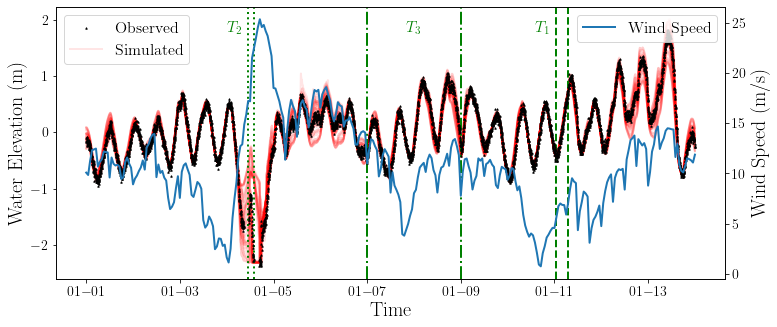

In [41]:
ax = adcirc_prob.plot_ts(max_plot=50)

ax2 = ax.twinx()
raw_data["met_data"]["wind_speed"] = np.sqrt(
    raw_data["met_data"]["u_wind"] ** 2 + raw_data["met_data"]["v_wind"] ** 2
)
raw_data["met_data"]["wind_speed"].plot(ax=ax2)

# Time windows
t_start_1 = "2018-01-11 01:00:00"
t_end_1 = "2018-01-11 07:00:00"

t_start_2 = "2018-01-04 11:00:00"
t_end_2 = "2018-01-04 14:00:00"

t_start_3 = "2018-01-07 00:00:00"
# t_start_3 = '2018-01-07 21:00:00'
t_end_3 = "2018-01-09 00:00:00"
# t_end_3 = '2018-01-09 00:00:00'

ylims = ax.get_ylim()
ax.plot(pd.to_datetime([t_start_1, t_start_1]), ylims, "g--")
ax.plot(pd.to_datetime([t_end_1, t_end_1]), ylims, "g--")
ax.text(pd.to_datetime("2018-01-10 14:00:00"), 1.8, "$T_1$", fontsize=16, color="g")

ax.plot(pd.to_datetime([t_start_2, t_start_2]), ylims, "g:")
ax.plot(pd.to_datetime([t_end_2, t_end_2]), ylims, "g:")
ax.text(pd.to_datetime("2018-01-04 00:00:00"), 1.8, "$T_2$", fontsize=16, color="g")

ax.plot(pd.to_datetime([t_start_3, t_start_3]), ylims, "g-.")
ax.plot(pd.to_datetime([t_end_3, t_end_3]), ylims, "g-.")
ax.text(pd.to_datetime("2018-01-07 20:00:00"), 1.8, "$T_3$", fontsize=16, color="g")

_ = ax.set_ylim(ylims)


myFmt = mdates.DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(myFmt)

ax.legend(["Observed", "Simulated"])
ax2.legend(["Wind Speed"])

ax.set_ylabel("Water Elevation (m)")
ax2.set_ylabel("Wind Speed (m/s)")
ax.set_xlabel("Time")
_ = ax2.set_title("")
_ = ax.set_title("")

save_figure(
    "adcirc_full_ts", "ADCiRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

# T1 Time Window
Good estimate of $\lambda_1$

In [9]:
t1_mask = np.logical_and(
    pd.to_datetime(raw_data["times"]) > t_start_1,
    pd.to_datetime(raw_data["times"]) < t_end_1,
)

In [10]:
ndata_1 = len([x for x in t1_mask if x])
ndata_1

119

### Using one Component

In [11]:
num_components = 1
prob_1 = adcirc_prob.mud_problem(
    method="pca", num_components=num_components, times_mask=t1_mask
)
mud_pt_1 = prob_1.estimate()
err = np.linalg.norm(raw_data["lam_ref"] - mud_pt_1)
mud_pt_1, prob_1.exp_r(), err

(array([0.06388482, 0.00201935]), 0.987867038157319, 0.003402797403362634)

### Compare to using two components

In [12]:
prob_1_2c = adcirc_prob.mud_problem(method="pca", num_components=2, times_mask=t1_mask)
mud_pt_1_2c = prob_1_2c.estimate()
err_2c = np.linalg.norm(raw_data["lam_ref"] - mud_pt_1)
mud_pt_1_2c, prob_1_2c.exp_r(), err_2c

(array([0.06681952, 0.00194287]), 0.4203828631382826, 0.003402797403362634)

## Time-Series with PCA Vector Weights

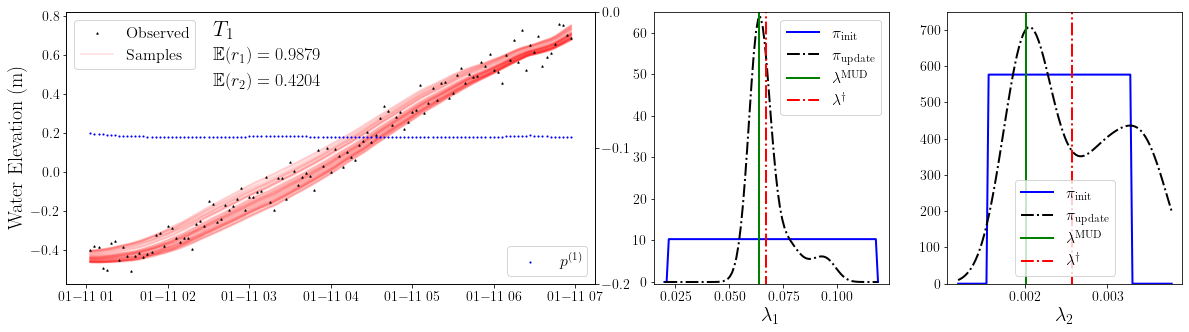

In [13]:
fig = plt.figure(figsize=(20, 5))

# PCA contours for each sample in new space
ax = fig.add_subplot(1, 4, (1, 2))
adcirc_prob.plot_ts(ax=ax, times=t1_mask, max_plot=50)
ax.text(raw_data["times"][t1_mask][30], 0.7, f"$T_1$", fontsize=22)
ax.text(
    raw_data["times"][t1_mask][30],
    0.57,
    f"$\mathbb{{E}}(r_1) = {prob_1.exp_r():0.4}$",
    fontsize=18,
)
ax.text(
    raw_data["times"][t1_mask][30],
    0.44,
    f"$\mathbb{{E}}(r_2) = {prob_1_2c.exp_r():0.4}$",  # f"$|\lambda^\dagger-\lambda^{{MUD}}| =$ {err:.1E}",
    fontsize=18,
)
# ax2.text(raw_data['times'][t1_mask][30], -0.09, f"$T_1$", fontsize=18)
# ax2.text(raw_data['times'][t1_mask][30], -0.0902, f"$\mathbb{{E}}(R) = {prob_1.exp_r():0.4}$", fontsize=18)
ax.legend(["Observed", "Samples"], loc="upper left")
ax.set_ylabel("Water Elevation (m)")

ax2 = ax.twinx()
ax2.scatter(
    raw_data["times"][t1_mask],
    adcirc_prob.pca["vecs"][0],
    color="blue",
    marker=".",
    s=5,
    label="$p^{(1)}$",
)
# ax2.scatter(raw_data['times'][t1_mask], adcirc_prob.pca["vecs"][1], color='orange', marker=".", s=5, label='$p^{(2)}$')
ax2.legend(loc="lower right")
ax2.set_ylim([-0.2, 0])
ax2.set_yticks([-0.2, -0.1, 0])

domain = np.array([[0.02, 0.12], [0.0012, 0.0038]])
# Plot Lambda 1
ax = fig.add_subplot(1, 4, 3)
prob_1.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.41, 65])
ax.legend()

ax = fig.add_subplot(1, 4, 4)
prob_1.plot_param_space(
    ax=ax,
    x_range=domain,
    param_idx=1,
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.01, 750])
ax.legend()

fig.subplots_adjust(wspace=0.25)
# fig.suptitle(f"$T_1 : \mathbb{{E}}(r_1) = {prob_1.exp_r():0.4}, \mathbb{{E}}(r_2) = {prob_1_2c.exp_r():0.4}$", fontsize=20)

save_figure(
    "pca_t1_res", "ADCIRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

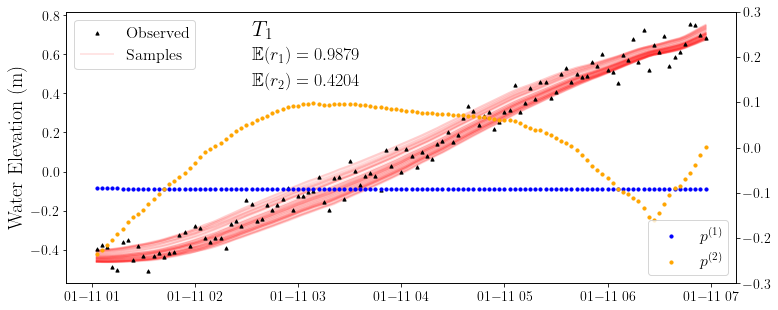

In [14]:
fig = plt.figure(figsize=(12, 5))

msize = 10
# One component
prob_1 = adcirc_prob.mud_problem(method="pca", num_components=1, times_mask=t1_mask)
mud_pt_1 = prob_1.estimate()
err = np.linalg.norm(raw_data["lam_ref"] - mud_pt_1)

# Two components
prob_1_2c = adcirc_prob.mud_problem(method="pca", num_components=2, times_mask=t1_mask)
mud_pt_1_2c = prob_1_2c.estimate()
err_2 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_1_2c)

exp_r_1_str = f"$\mathbb{{E}}(r_1) = {prob_1.exp_r():0.4}$"
exp_r_2_str = f"$\mathbb{{E}}(r_2) = {prob_1_2c.exp_r():0.4}$"

# Time Series
ax = fig.add_subplot(1, 1, 1)
adcirc_prob.plot_ts(ax=ax, times=t1_mask, max_plot=50, meas_kwargs={"s": msize})
ax.text(raw_data["times"][t1_mask][30], 0.7, f"$T_1$", fontsize=22)
ax.text(
    raw_data["times"][t1_mask][30],
    0.57,
    exp_r_1_str,
    fontsize=18,
)
ax.text(
    raw_data["times"][t1_mask][30],
    0.44,
    exp_r_2_str,
    fontsize=18,
)
ax.legend(["Observed", "Samples"], loc="upper left")
ax.set_ylabel("Water Elevation (m)")

# PCA Vectors
ax2 = ax.twinx()
ax2.scatter(
    raw_data["times"][t1_mask],
    adcirc_prob.pca["vecs"][0],
    color="blue",
    marker="o",
    s=msize,
    label="$p^{(1)}$",
)
ax2.scatter(
    raw_data["times"][t1_mask],
    adcirc_prob.pca["vecs"][1],
    color="orange",
    marker="o",
    s=msize,
    label="$p^{(2)}$",
)
ax2.legend(loc="lower right")
# ax2.set_ylabel("$p^{(\ell)}_i$")
ax2.set_ylim([-0.3, 0.3])


save_figure(
    "pca_t1_vecs", "ADCIRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

## Updated Distributions

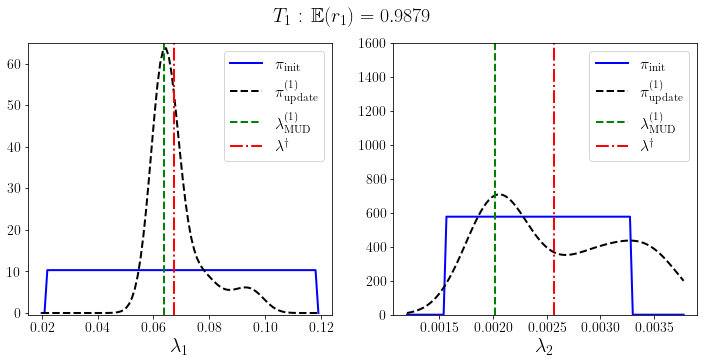

In [50]:
fig = plt.figure(figsize=(12, 5))

msize = 10
# One component
prob_1 = adcirc_prob.mud_problem(method="pca", num_components=1, times_mask=t1_mask)
mud_pt_1 = prob_1.estimate()
err = np.linalg.norm(raw_data["lam_ref"] - mud_pt_1)

# Two components
prob_1_2c = adcirc_prob.mud_problem(method="pca", num_components=2, times_mask=t1_mask)
mud_pt_1_2c = prob_1_2c.estimate()
err_2 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_1_2c)

exp_r_1_str = f"$\mathbb{{E}}(r_1) = {prob_1.exp_r():0.4}$"

# Plot Lambda 1
height = 65
domain = np.array([[0.02, 0.12], [0.0012, 0.0038]])
ax = fig.add_subplot(1, 2, 1)
ax.set_ylim([-0.41, height])
prob_1.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(1)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(1)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.41, height])
ax.legend()

height = 1600
ax = fig.add_subplot(1, 2, 2)
ax.set_ylim([-0.01, height])
prob_1.plot_param_space(
    ax=ax,
    x_range=domain,
    param_idx=1,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(1)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(1)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.01, height])
ax.legend()

# fig.subplots_adjust(wspace=0.25)
fig.suptitle(f"$T_1$ : {exp_r_1_str}", fontsize=20)

save_figure(
    "pca_t1_1_comp", "ADCIRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

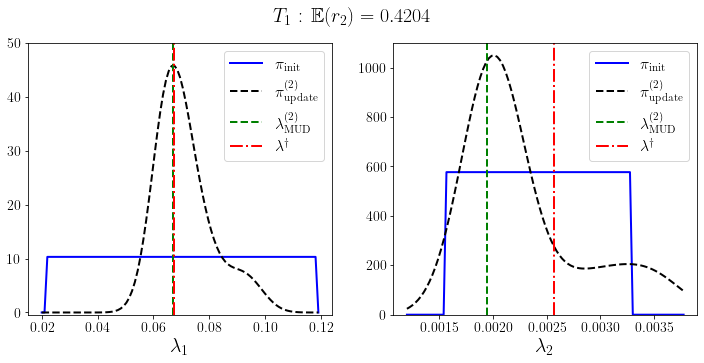

In [51]:
fig = plt.figure(figsize=(12, 5))

msize = 10
# Two components
prob_1_2c = adcirc_prob.mud_problem(method="pca", num_components=2, times_mask=t1_mask)
mud_pt_1_2c = prob_1_2c.estimate()
err_2 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_1_2c)

exp_r_1_str = f"$\mathbb{{E}}(r_1) = {prob_1.exp_r():0.4}$"
exp_r_2_str = f"$\mathbb{{E}}(r_2) = {prob_1_2c.exp_r():0.4}$"


# Plot Lambda 1
height = 50
domain = np.array([[0.02, 0.12], [0.0012, 0.0038]])
ax = fig.add_subplot(1, 2, 1)
ax.set_ylim([-0.41, height])
prob_1_2c.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(2)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(2)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.41, height])
ax.legend()

height = 1100
ax = fig.add_subplot(1, 2, 2)
ax.set_ylim([-0.01, height])
prob_1_2c.plot_param_space(
    ax=ax,
    param_idx=1,
    x_range=domain,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(2)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(2)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.01, height])
ax.legend()

# fig.subplots_adjust(wspace=0.25)
fig.suptitle(f"$T_1$ : {exp_r_2_str}", fontsize=20)

save_figure(
    "pca_t1_2_comp", "ADCIRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

## Learned QoI

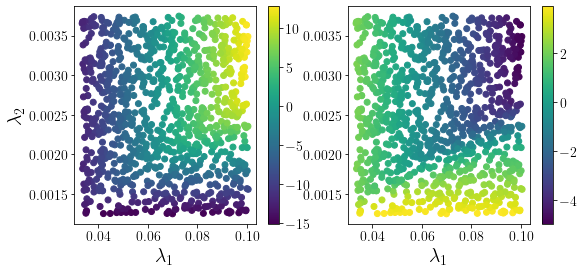

In [27]:
fig = plt.figure(figsize=(9, 4))

for i in range(num_components):
    ax = fig.add_subplot(1, 2, i + 1)
    prob_1.plot_params_2d(ax=ax, y=i, colorbar=True)
    if i == 1:
        ax.set_ylabel("")

# T2 Time Window

In [42]:
t2_mask = np.logical_and(
    pd.to_datetime(raw_data["times"]) > t_start_2,
    pd.to_datetime(raw_data["times"]) < t_end_2,
)

In [43]:
ndata_2 = len([x for x in t2_mask if x])
ndata_2

53

In [44]:
num_components = 1
prob_2 = adcirc_prob.mud_problem(
    method="pca", num_components=num_components, times_mask=t2_mask
)
mud_pt_2 = prob_2.estimate()
err_2 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_2)
mud_pt_2, prob_2.exp_r(), err_2

(array([0.04375455, 0.00256695]), 1.0387382766297366, 0.023488506378676423)

Compare to using two components

In [45]:
prob_2_2c = adcirc_prob.mud_problem(method="pca", num_components=2, times_mask=t2_mask)
mud_pt_2_2c = prob_2_2c.estimate()
err_2_2c = np.linalg.norm(raw_data["lam_ref"] - mud_pt_2_2c)
mud_pt_2_2c, prob_2_2c.exp_r(), err_2_2c

(array([0.04375455, 0.00256695]), 4.420243397282121, 0.023488506378676423)

## Time-Series with PCA Vector Weights

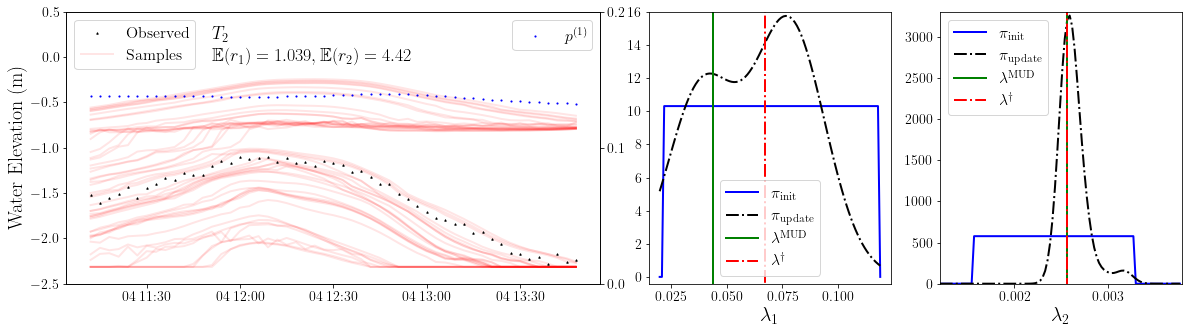

In [20]:
fig = plt.figure(figsize=(20, 5))

# PCA contours for each sample in new space
ax = fig.add_subplot(1, 4, (1, 2))
adcirc_prob.plot_ts(ax=ax, times=t2_mask, max_plot=50)
ax.text(raw_data["times"][t2_mask][13], 0.20, f"$T_2$", fontsize=18)
ax.text(
    raw_data["times"][t2_mask][13],
    -0.05,
    f"$\mathbb{{E}}(r_1) = {prob_2.exp_r():0.4}, \mathbb{{E}}(r_2) = {prob_2_2c.exp_r():0.4}$",  # $|\lambda^\dagger-\lambda^{{MUD}}| =${err_2:.1E}",
    fontsize=18,
)
ax.set_ylim([-2.5, 0.5])
ax.legend(["Observed", "Samples"], loc="upper left")
ax.set_ylabel("Water Elevation (m)")

ax2 = ax.twinx()
ax2.scatter(
    raw_data["times"][t2_mask],
    adcirc_prob.pca["vecs"][0],
    color="blue",
    marker=".",
    s=5,
    label="$p^{(1)}$",
)
ax2.legend(loc="upper right")
ax2.set_ylim([0, 0.2])
ax2.set_yticks([0, 0.1, 0.2])

domain = np.array([[0.02, 0.12], [0.0012, 0.0038]])
# Plot Lambda 1
ax = fig.add_subplot(1, 4, 3)
prob_2.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_xlabel("$\lambda_1$")
ax.set_ylim([-0.41, 16])
ax.legend()

ax = fig.add_subplot(1, 4, 4)
prob_2.plot_param_space(
    ax=ax,
    x_range=domain,
    param_idx=1,
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_xlabel("$\lambda_2$")
ax.set_xlim(domain[1])
ax.set_ylim([-0.01, 3300])
ax.legend()

save_figure(
    "pca_t2_res", "ADCiRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

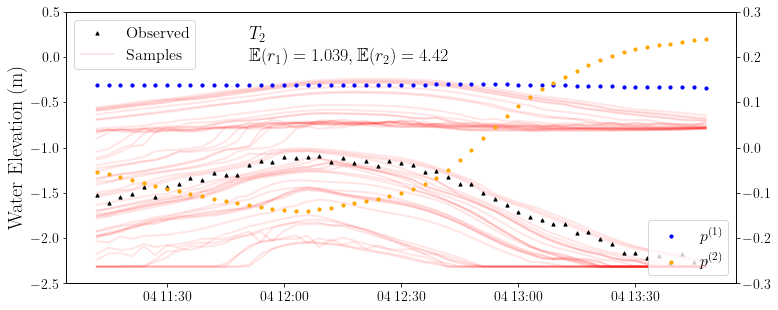

In [23]:
fig = plt.figure(figsize=(12, 5))
msize = 10

# One component
prob_2 = adcirc_prob.mud_problem(method="pca", num_components=1, times_mask=t2_mask)
mud_pt_2 = prob_2.estimate()
err = np.linalg.norm(raw_data["lam_ref"] - mud_pt_2)

# Two components
prob_2_2c = adcirc_prob.mud_problem(method="pca", num_components=2, times_mask=t2_mask)
mud_pt_2_2c = prob_2_2c.estimate()
err_2 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_2_2c)

exp_r_1_str = f"$\mathbb{{E}}(r_1) = {prob_2.exp_r():0.4}$"
exp_r_2_str = f"$\mathbb{{E}}(r_2) = {prob_2_2c.exp_r():0.4}$"

# Time Series
ax = fig.add_subplot(1, 1, 1)
adcirc_prob.plot_ts(ax=ax, times=t2_mask, max_plot=50, meas_kwargs={"s": msize})
ax.text(raw_data["times"][t2_mask][13], 0.20, f"$T_2$", fontsize=18)
ax.text(
    raw_data["times"][t2_mask][13],
    -0.05,
    f"$\mathbb{{E}}(r_1) = {prob_2.exp_r():0.4}, \mathbb{{E}}(r_2) = {prob_2_2c.exp_r():0.4}$",  # $|\lambda^\dagger-\lambda^{{MUD}}| =${err_2:.1E}",
    fontsize=18,
)
ax.set_ylim([-2.5, 0.5])
ax.legend(["Observed", "Samples"], loc="upper left")
ax.set_ylabel("Water Elevation (m)")

# PCA Vectors
ax2 = ax.twinx()
ax2.scatter(
    raw_data["times"][t2_mask],
    adcirc_prob.pca["vecs"][0],
    color="blue",
    marker="o",
    s=msize,
    label="$p^{(1)}$",
)
ax2.scatter(
    raw_data["times"][t2_mask],
    adcirc_prob.pca["vecs"][1],
    color="orange",
    marker="o",
    s=msize,
    label="$p^{(2)}$",
)
ax2.legend(loc="lower right")
# ax2.set_ylabel("$p^{(\ell)}_i$")
ax2.set_ylim([-0.3, 0.3])

# fig.subplots_adjust(wspace=0.25)
# fig.suptitle(f"$T_1 : \mathbb{{E}}(r_1) = {prob_1.exp_r():0.4}, \mathbb{{E}}(r_2) = {prob_1_2c.exp_r():0.4}$", fontsize=20)

save_figure(
    "pca_t2_vecs", "ADCIRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

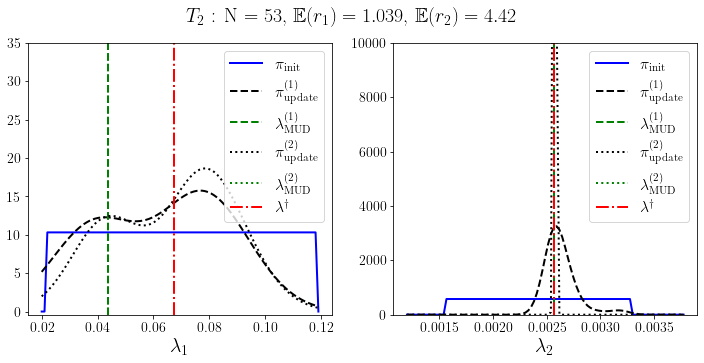

In [91]:
fig = plt.figure(figsize=(12, 5))

msize = 10
# One component
prob_2 = adcirc_prob.mud_problem(method="pca", num_components=1, times_mask=t2_mask)
mud_pt_2 = prob_2.estimate()
err = np.linalg.norm(raw_data["lam_ref"] - mud_pt_2)

# Two components
prob_2_2c = adcirc_prob.mud_problem(method="pca", num_components=2, times_mask=t2_mask)
mud_pt_2_2c = prob_2_2c.estimate()
err_2 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_2_2c)

exp_r_1_str = f"$\mathbb{{E}}(r_1) = {prob_2.exp_r():0.4}$"
exp_r_2_str = f"$\mathbb{{E}}(r_2) = {prob_2_2c.exp_r():0.4}$"

# Time Series
# ax.text(raw_data["times"][t2_mask][30], 0.7, f"$T_2$", fontsize=22)
# ax.text(
#     raw_data["times"][t2_mask][30],
#     0.57,
#     exp_r_2_str,
#     fontsize=18,
# )
# ax.text(
#     raw_data["times"][t2_mask][30],
#     0.44,
#     exp_r_2_str,
#     fontsize=18,
# )

# Plot Lambda 1
height = 35
domain = np.array([[0.02, 0.12], [0.0012, 0.0038]])
ax = fig.add_subplot(1, 2, 1)
ax.set_ylim([-0.41, height])
prob_2.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(1)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(1)}$"},
)
prob_2_2c.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    in_opts=None,
    up_opts={"linestyle": ":", "label": "$\pi_\\text{update}^{(2)}$"},
    mud_opts={"linestyle": ":", "label": "$\lambda_\\text{MUD}^{(2)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.41, height])
ax.legend()

height = 10000
ax = fig.add_subplot(1, 2, 2)
ax.set_ylim([-0.01, height])
prob_2.plot_param_space(
    ax=ax,
    x_range=domain,
    param_idx=1,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(1)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(1)}$"},
)
prob_2_2c.plot_param_space(
    ax=ax,
    param_idx=1,
    x_range=domain,
    in_opts=None,
    up_opts={"linestyle": ":", "label": "$\pi_\\text{update}^{(2)}$"},
    mud_opts={"linestyle": ":", "label": "$\lambda_\\text{MUD}^{(2)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.01, height])
ax.legend()

# fig.subplots_adjust(wspace=0.25)
fig.suptitle(f"$T_2$ : N = {ndata_2}, {exp_r_1_str}, {exp_r_2_str}", fontsize=20)

save_figure(
    "pca_t2_res_3", "ADCIRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

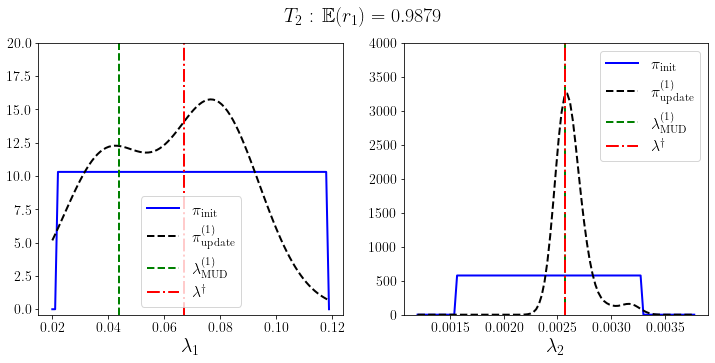

In [46]:
fig = plt.figure(figsize=(12, 5))

msize = 10
# One component
prob_2 = adcirc_prob.mud_problem(method="pca", num_components=1, times_mask=t2_mask)
mud_pt_2 = prob_2.estimate()
err = np.linalg.norm(raw_data["lam_ref"] - mud_pt_2)

# Plot Lambda 1
height = 20
domain = np.array([[0.02, 0.12], [0.0012, 0.0038]])
ax = fig.add_subplot(1, 2, 1)
ax.set_ylim([-0.41, height])
prob_2.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(1)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(1)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.41, height])
ax.legend()

height = 4000
ax = fig.add_subplot(1, 2, 2)
ax.set_ylim([-0.01, height])
prob_2.plot_param_space(
    ax=ax,
    x_range=domain,
    param_idx=1,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(1)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(1)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.01, height])
ax.legend()

# fig.subplots_adjust(wspace=0.25)
fig.suptitle(f"$T_2$ : {exp_r_1_str}", fontsize=20)

save_figure(
    "pca_t2_1_comp", "ADCIRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

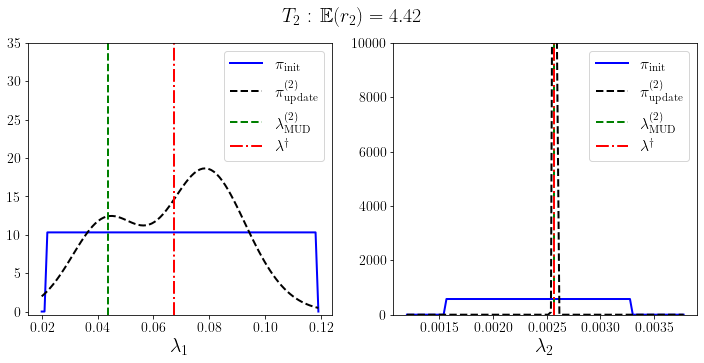

In [47]:
fig = plt.figure(figsize=(12, 5))

msize = 10

# Two components
prob_2_2c = adcirc_prob.mud_problem(method="pca", num_components=2, times_mask=t2_mask)
mud_pt_2_2c = prob_2_2c.estimate()
err_2 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_2_2c)

exp_r_2_str = f"$\mathbb{{E}}(r_2) = {prob_2_2c.exp_r():0.4}$"

# Plot Lambda 1
height = 35
domain = np.array([[0.02, 0.12], [0.0012, 0.0038]])
ax = fig.add_subplot(1, 2, 1)
ax.set_ylim([-0.41, height])
prob_2_2c.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(2)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(2)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.41, height])
ax.legend()

height = 10000
ax = fig.add_subplot(1, 2, 2)
ax.set_ylim([-0.01, height])
prob_2_2c.plot_param_space(
    ax=ax,
    param_idx=1,
    x_range=domain,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(2)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(2)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.01, height])
ax.legend()

# fig.subplots_adjust(wspace=0.25)
fig.suptitle(f"$T_2$ : {exp_r_2_str}", fontsize=20)

save_figure(
    "pca_t2_2_comp", "ADCIRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

## Learned QoI

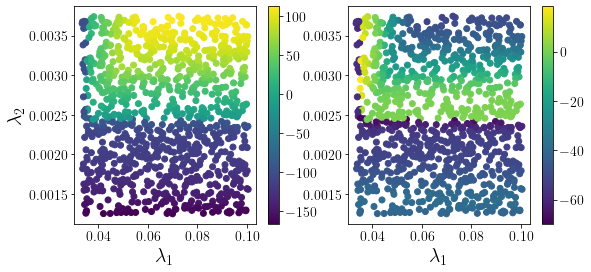

In [34]:
fig = plt.figure(figsize=(9, 4))

for i in range(num_components):
    ax = fig.add_subplot(1, 2, i + 1)
    prob_2.plot_params_2d(ax=ax, y=i, colorbar=True)
    if i == 1:
        ax.set_ylabel("")

## Updated Distributions

# T3 Time Window

Good estimate for both parameters

In [24]:
t3_mask = np.logical_and(
    pd.to_datetime(raw_data["times"]) > t_start_3,
    pd.to_datetime(raw_data["times"]) < t_end_3,
)

In [25]:
ndata_3 = len([x for x in t3_mask if x])
ndata_3

959

In [26]:
prob_3_1c = adcirc_prob.mud_problem(method="pca", num_components=1, times_mask=t3_mask)
mud_pt_3_1c = prob_3_1c.estimate()
err_3_1c = np.linalg.norm(raw_data["lam_ref"] - mud_pt_3_1c)
mud_pt_3_1c, prob_3_1c.exp_r(), err_3_1c

(array([0.09536948, 0.00253302]), 1.237828205249338, 0.028126438238384115)

In [28]:
num_components = 2
prob_3_2c = adcirc_prob.mud_problem(
    method="pca", num_components=num_components, times_mask=t3_mask
)
mud_pt_3 = prob_3_2c.estimate()
err_3 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_3)
mud_pt_3, prob_3_2c.exp_r(), err_3
mud_pt_3, prob_3_2c.exp_r()

(array([0.06921228, 0.00258415]), 0.9084991156247542)

## Time-Series with PCA Vector Weights

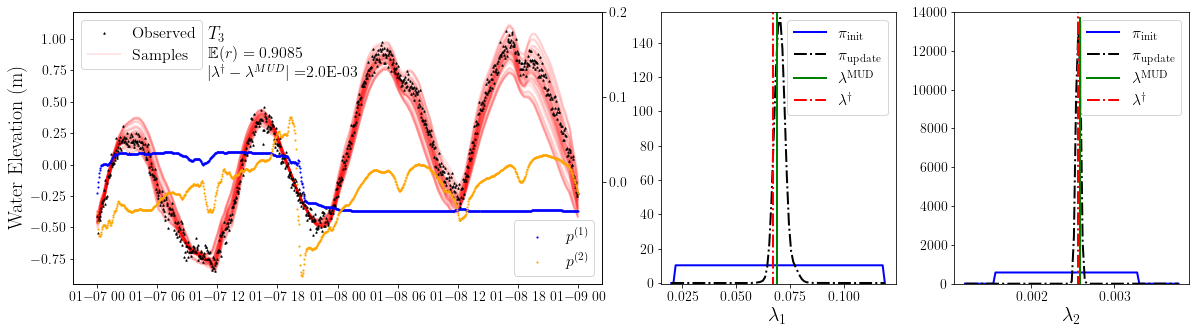

In [13]:
fig = plt.figure(figsize=(20, 5))

# PCA contours for each sample in new space
ax = fig.add_subplot(1, 4, (1, 2))
adcirc_prob.plot_ts(ax=ax, times=t3_mask, max_plot=50)  # Plot TS for 3rd time window
ax.text(  # Add Text Indicating Time Window
    raw_data["times"][t3_mask][220], 1.00, f"$T_3$", fontsize=18
)
ax.text(  # Add Text indiicating Exp(r)
    raw_data["times"][t3_mask][220],
    0.85,
    f"$\mathbb{{E}}(r) = {prob_3.exp_r():0.4}$",
    fontsize=16,
)
ax.text(  # Add Text indiicating Error
    raw_data["times"][t3_mask][220],
    0.70,
    f"$|\lambda^\dagger-\lambda^{{MUD}}|=${err_3:.1E}",
    fontsize=16,
)
ax.legend(["Observed", "Samples"], loc="upper left")
ax.set_ylabel("Water Elevation (m)")

ax2 = ax.twinx()
ax2.scatter(  # Plot First Principal Component
    raw_data["times"][t3_mask],
    adcirc_prob.pca["vecs"][0],
    color="blue",
    marker=".",
    s=5,
    label="$p^{(1)}$",
)
ax2.scatter(  # Plot Second Principal Component
    raw_data["times"][t3_mask],
    adcirc_prob.pca["vecs"][1],
    color="orange",
    marker=".",
    s=5,
    label="$p^{(2)}$",
)
ax2.legend(loc="lower right")
ax2.set_yticks([0, 0.1, 0.2])

# Plot Lambda 1
domain = np.array([[0.02, 0.12], [0.0012, 0.0038]])
ax = fig.add_subplot(1, 4, 3)
prob_3.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.41, 158])
ax.legend()

ax = fig.add_subplot(1, 4, 4)
prob_3.plot_param_space(
    ax=ax,
    x_range=domain,
    param_idx=1,
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.01, 14000])
ax.legend()

save_figure("pca_t3_res", "ADCiRC", close_fig=False, dpi=250, bbox_inches="tight")

fig.subplots_adjust(wspace=0.25)

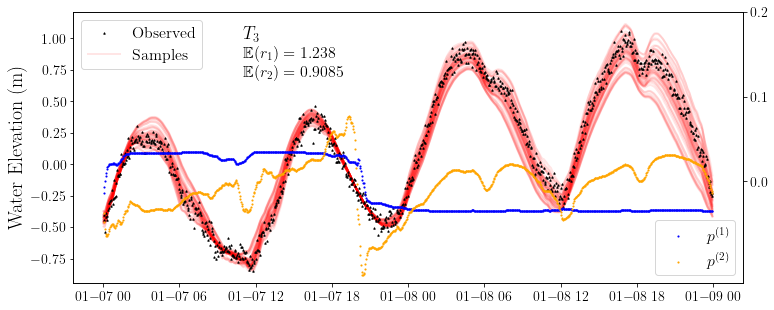

In [14]:
fig = plt.figure(figsize=(12, 5))

# One component
prob_3 = adcirc_prob.mud_problem(method="pca", num_components=1, times_mask=t3_mask)
mud_pt_3 = prob_3.estimate()
err = np.linalg.norm(raw_data["lam_ref"] - mud_pt_3)

# Two components
prob_3_2c = adcirc_prob.mud_problem(method="pca", num_components=2, times_mask=t3_mask)
mud_pt_3_2c = prob_3_2c.estimate()
err_2 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_3_2c)

exp_r_1_str = f"$\mathbb{{E}}(r_1) = {prob_3.exp_r():0.4}$"
exp_r_2_str = f"$\mathbb{{E}}(r_2) = {prob_3_2c.exp_r():0.4}$"

# Time Series
ax = fig.add_subplot(1, 1, 1)
adcirc_prob.plot_ts(ax=ax, times=t3_mask, max_plot=50)  # Plot TS for 3rd time window
ax.text(  # Add Text Indicating Time Window
    raw_data["times"][t3_mask][220], 1.00, f"$T_3$", fontsize=18
)
ax.text(  # Add Text indiicating Exp(r)
    raw_data["times"][t3_mask][220],
    0.85,
    exp_r_1_str,
    fontsize=16,
)
ax.text(  # Add Text indiicating Error
    raw_data["times"][t3_mask][220],
    0.70,
    exp_r_2_str,
    fontsize=16,
)
ax.legend(["Observed", "Samples"], loc="upper left")
ax.set_ylabel("Water Elevation (m)")

ax2 = ax.twinx()
ax2.scatter(  # Plot First Principal Component
    raw_data["times"][t3_mask],
    adcirc_prob.pca["vecs"][0],
    color="blue",
    marker=".",
    s=5,
    label="$p^{(1)}$",
)
ax2.scatter(  # Plot Second Principal Component
    raw_data["times"][t3_mask],
    adcirc_prob.pca["vecs"][1],
    color="orange",
    marker=".",
    s=5,
    label="$p^{(2)}$",
)
ax2.legend(loc="lower right")
ax2.set_yticks([0, 0.1, 0.2])


# fig.subplots_adjust(wspace=0.25)
# fig.suptitle(f"$T_1 : \mathbb{{E}}(r_1) = {prob_1.exp_r():0.4}, \mathbb{{E}}(r_2) = {prob_1_2c.exp_r():0.4}$", fontsize=20)

save_figure(
    "pca_t3_vecs", "ADCIRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

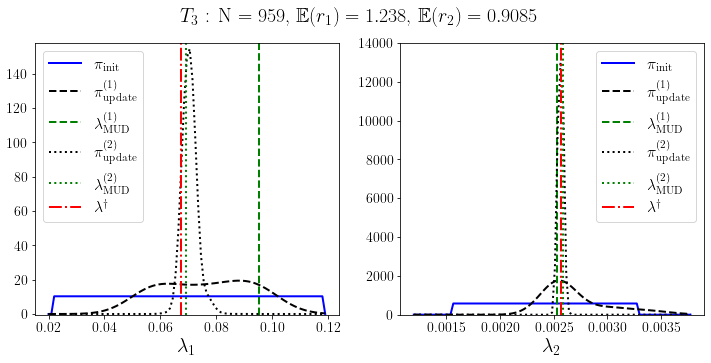

In [15]:
fig = plt.figure(figsize=(12, 5))

msize = 10
# One component
prob_3 = adcirc_prob.mud_problem(method="pca", num_components=1, times_mask=t3_mask)
mud_pt_3 = prob_3.estimate()
err = np.linalg.norm(raw_data["lam_ref"] - mud_pt_3)

# Two components
prob_3_2c = adcirc_prob.mud_problem(method="pca", num_components=2, times_mask=t3_mask)
mud_pt_3_2c = prob_3_2c.estimate()
err_3 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_3_2c)

exp_r_1_str = f"$\mathbb{{E}}(r_1) = {prob_3.exp_r():0.4}$"
exp_r_2_str = f"$\mathbb{{E}}(r_2) = {prob_3_2c.exp_r():0.4}$"

# Time Series
# ax.text(raw_data["times"][t3_mask][30], 0.7, f"$T_3$", fontsize=22)
# ax.text(
#     raw_data["times"][t3_mask][30],
#     0.57,
#     exp_r_3_str,
#     fontsize=18,
# )
# ax.text(
#     raw_data["times"][t3_mask][30],
#     0.44,
#     exp_r_3_str,
#     fontsize=18,
# )

# Plot Lambda 1
height = 158
domain = np.array([[0.02, 0.12], [0.0012, 0.0038]])
ax = fig.add_subplot(1, 2, 1)
ax.set_ylim([-0.41, height])
prob_3.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(1)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(1)}$"},
)
prob_3_2c.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    in_opts=None,
    up_opts={"linestyle": ":", "label": "$\pi_\\text{update}^{(2)}$"},
    mud_opts={"linestyle": ":", "label": "$\lambda_\\text{MUD}^{(2)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.41, height])
ax.legend()

height = 14000
ax = fig.add_subplot(1, 2, 2)
ax.set_ylim([-0.01, height])
prob_3.plot_param_space(
    ax=ax,
    x_range=domain,
    param_idx=1,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(1)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(1)}$"},
)
prob_3_2c.plot_param_space(
    ax=ax,
    param_idx=1,
    x_range=domain,
    in_opts=None,
    up_opts={"linestyle": ":", "label": "$\pi_\\text{update}^{(2)}$"},
    mud_opts={"linestyle": ":", "label": "$\lambda_\\text{MUD}^{(2)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.01, height])
ax.legend()

# fig.subplots_adjust(wspace=0.25)
fig.suptitle(f"$T_3$ : N = {ndata_3}, {exp_r_1_str}, {exp_r_2_str}", fontsize=20)

save_figure(
    "pca_t3_res_3", "ADCIRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

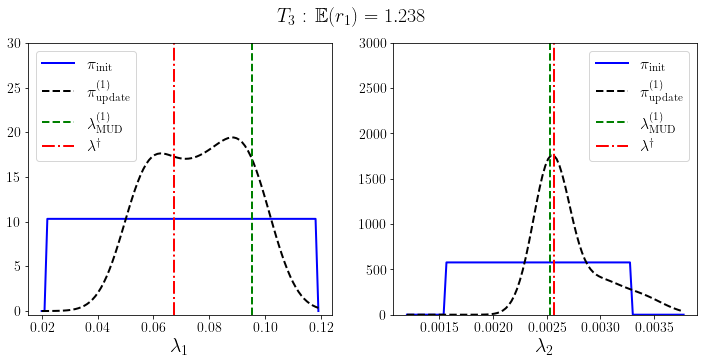

In [52]:
fig = plt.figure(figsize=(12, 5))

msize = 10
# One component
prob_3 = adcirc_prob.mud_problem(method="pca", num_components=1, times_mask=t3_mask)
mud_pt_3 = prob_3.estimate()
err = np.linalg.norm(raw_data["lam_ref"] - mud_pt_3)

exp_r_1_str = f"$\mathbb{{E}}(r_1) = {prob_3.exp_r():0.4}$"

# Plot Lambda 1
height = 30
domain = np.array([[0.02, 0.12], [0.0012, 0.0038]])
ax = fig.add_subplot(1, 2, 1)
ax.set_ylim([-0.41, height])
prob_3.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(1)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(1)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.41, height])
ax.legend()

height = 3000
ax = fig.add_subplot(1, 2, 2)
ax.set_ylim([-0.01, height])
prob_3.plot_param_space(
    ax=ax,
    x_range=domain,
    param_idx=1,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(1)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(1)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.01, height])
ax.legend()

# fig.subplots_adjust(wspace=0.25)
fig.suptitle(f"$T_3$ : {exp_r_1_str}", fontsize=20)

save_figure(
    "pca_t3_1_comp", "ADCIRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

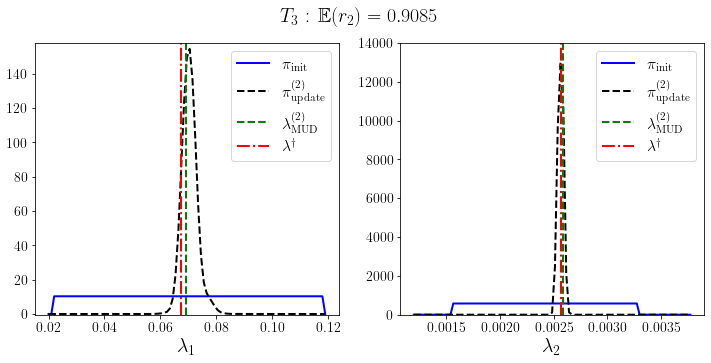

In [53]:
fig = plt.figure(figsize=(12, 5))

msize = 10

# Two components
prob_3_2c = adcirc_prob.mud_problem(method="pca", num_components=2, times_mask=t3_mask)
mud_pt_3_2c = prob_3_2c.estimate()
err_3 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_3_2c)

exp_r_2_str = f"$\mathbb{{E}}(r_2) = {prob_3_2c.exp_r():0.4}$"

# Plot Lambda 1
height = 158
domain = np.array([[0.02, 0.12], [0.0012, 0.0038]])
ax = fig.add_subplot(1, 2, 1)
ax.set_ylim([-0.41, height])
prob_3_2c.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(2)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(2)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.41, height])
ax.legend()

height = 14000
ax = fig.add_subplot(1, 2, 2)
ax.set_ylim([-0.01, height])
prob_3_2c.plot_param_space(
    ax=ax,
    param_idx=1,
    x_range=domain,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(2)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(2)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.01, height])
ax.legend()

# fig.subplots_adjust(wspace=0.25)
fig.suptitle(f"$T_3$ : {exp_r_2_str}", fontsize=20)

save_figure(
    "pca_t3_2_comp", "ADCIRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

## Learned QoI

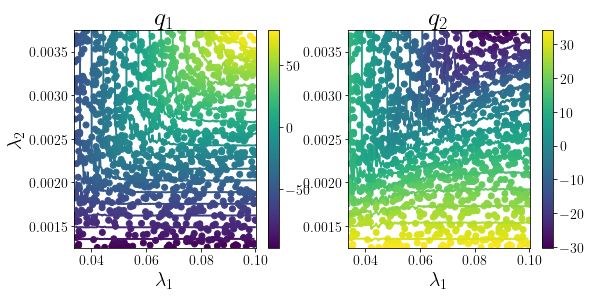

In [74]:
fig = plt.figure(figsize=(9, 4))

for i in range(num_components):
    ax = fig.add_subplot(1, 2, i + 1)
    prob_3.plot_params_2d(ax=ax, y=i, contours=True, colorbar=True)
    if i == 1:
        ax.set_ylabel("")

## Updated Distributions

# All Data

In [125]:
num_components = 2
prob_4 = adcirc_prob.mud_problem(method="pca", num_components=num_components)
mud_pt_4 = prob_4.estimate()
mud_pt_4, prob_4.exp_r()

(array([0.06921228, 0.00258415]), 0.6302202272982242)

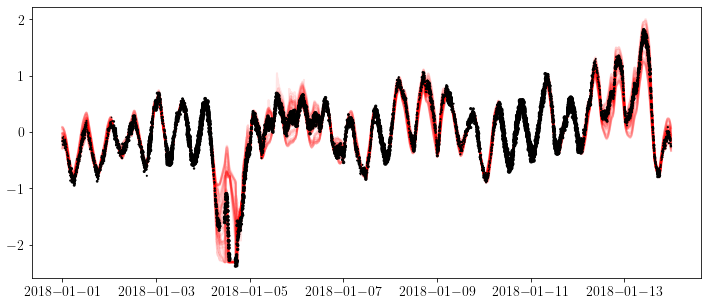

In [126]:
ax = adcirc_prob.plot_ts(
    max_plot=50,
    meas_kwargs={"marker": "o", "s": 500 * np.abs(adcirc_prob.pca["vecs"][1])},
)

## Time-Series with PCA Vector Weights

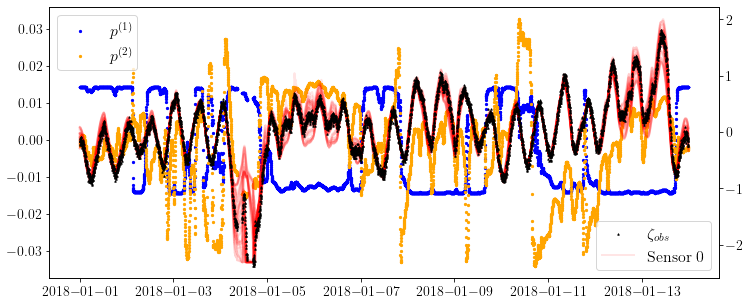

In [122]:
fig = plt.figure(figsize=(12, 5))

# PCA contours for each sample in new space
ax = fig.add_subplot(1, 1, 1)
plt.scatter(
    raw_data["times"],
    adcirc_prob.pca["vecs"][0],
    color="blue",
    marker=".",
    s=20,
    label="$p^{(1)}$",
)
plt.scatter(
    raw_data["times"],
    adcirc_prob.pca["vecs"][1],
    color="orange",
    marker=".",
    s=20,
    label="$p^{(2)}$",
)

ax2 = ax.twinx()
adcirc_prob.plot_ts(ax=ax2, max_plot=50)

ax.legend(loc="upper left")
ax2.legend(loc="lower right")

save_figure("pca_vectors_all", "ADCiRC", close_fig=False, dpi=500, bbox_inches="tight")

# Get lims from this pont to set colorbar for contour plots
lims = ax.get_ylim()

## Learned QoI

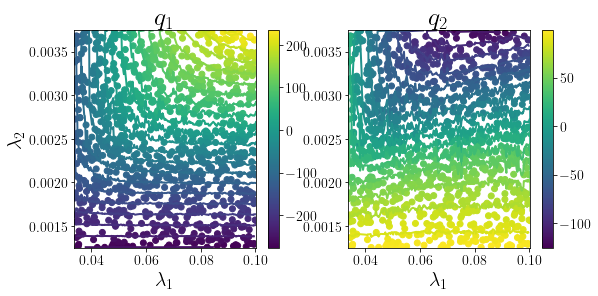

In [58]:
fig = plt.figure(figsize=(9, 4))

for i in range(num_components):
    ax = fig.add_subplot(1, 2, i + 1)
    prob_4.plot_params_2d(ax=ax, y=i, contours=True, colorbar=True)
    if i == 1:
        ax.set_ylabel("")

## Updated Distributions

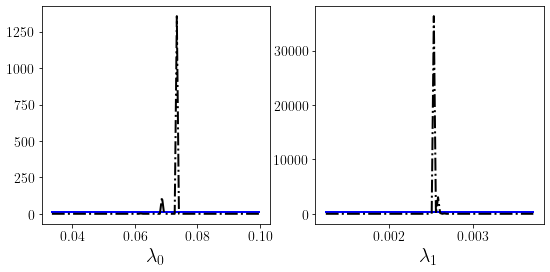

In [127]:
fig = plt.figure(figsize=(9, 4))


# Plot Lambda 1
ax = fig.add_subplot(1, 2, 1)
prob_4.plot_param_space(
    ax=ax,
    param_idx=0,
    mud_opts=None,
    true_opts=None,
)
ax = fig.add_subplot(1, 2, 2)
prob_4.plot_param_space(
    ax=ax,
    param_idx=1,
    mud_opts=None,
    true_opts=None,
)

# T_4

Use $T_1$ and $T_2$

In [55]:
t4_mask = np.logical_or(t1_mask, t2_mask)

In [56]:
len([x for x in t4_mask if x])

172

In [69]:
prob_4_1c = adcirc_prob.mud_problem(method="pca", num_components=1, times_mask=t4_mask)
mud_pt_4_1c = prob_4_1c.estimate()
err_4_1c = np.linalg.norm(raw_data["lam_ref"] - mud_pt_4_1c)
mud_pt_4_1c, prob_4_1c.exp_r(), err_4_1c

(array([0.07714696, 0.00250076]), 1.266219375843356, 0.009904125493405764)

In [70]:
num_components = 2
prob_4 = adcirc_prob.mud_problem(
    method="pca", num_components=num_components, times_mask=t4_mask
)
mud_pt_4 = prob_4.estimate()
err_4 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_4)
mud_pt_4, prob_4.exp_r(), err_4

(array([0.06921228, 0.00258415]), 0.2489968495529167, 0.001969283613291976)

In [71]:
#

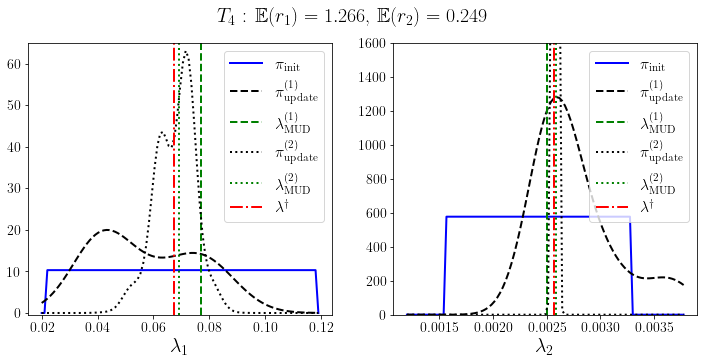

In [72]:
fig = plt.figure(figsize=(12, 5))

msize = 10
# One component
prob_4 = adcirc_prob.mud_problem(method="pca", num_components=1, times_mask=t4_mask)
mud_pt_4 = prob_4.estimate()
err = np.linalg.norm(raw_data["lam_ref"] - mud_pt_4)

# Two components
prob_4_2c = adcirc_prob.mud_problem(method="pca", num_components=2, times_mask=t4_mask)
mud_pt_4_2c = prob_4_2c.estimate()
err_2 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_4_2c)

exp_r_1_str = f"$\mathbb{{E}}(r_1) = {prob_4.exp_r():0.4}$"
exp_r_2_str = f"$\mathbb{{E}}(r_2) = {prob_4_2c.exp_r():0.4}$"

# Plot Lambda 1
domain = np.array([[0.02, 0.12], [0.0012, 0.0038]])
ax = fig.add_subplot(1, 2, 1)
ax.set_ylim([-0.41, 65])
prob_4.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(1)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(1)}$"},
)
prob_4_2c.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    in_opts=None,
    up_opts={"linestyle": ":", "label": "$\pi_\\text{update}^{(2)}$"},
    mud_opts={"linestyle": ":", "label": "$\lambda_\\text{MUD}^{(2)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.41, 65])
ax.legend()

height = 1600
ax = fig.add_subplot(1, 2, 2)
ax.set_ylim([-0.01, height])
prob_4.plot_param_space(
    ax=ax,
    x_range=domain,
    param_idx=1,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(1)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(1)}$"},
)
prob_4_2c.plot_param_space(
    ax=ax,
    param_idx=1,
    x_range=domain,
    in_opts=None,
    up_opts={"linestyle": ":", "label": "$\pi_\\text{update}^{(2)}$"},
    mud_opts={"linestyle": ":", "label": "$\lambda_\\text{MUD}^{(2)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.01, height])
ax.legend()

# fig.subplots_adjust(wspace=0.25)
fig.suptitle(f"$T_4$ : {exp_r_1_str}, {exp_r_2_str}", fontsize=20)

save_figure(
    "pca_t4_res_3", "ADCIRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

# Iterative $T_1$ and then $T_2$

## First iteration

In [81]:
prob_5_1 = adcirc_prob.mud_problem(method="pca", num_components=1, times_mask=t1_mask)
mud_pt_5_1 = prob_5_1.estimate()
err_5_1 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_5_1)
mud_pt_5_1, prob_5_1.exp_r(), err_5_1

(array([0.06388482, 0.00201935]), 0.987867038157319, 0.003402797403362634)

## Second Iteration

In [82]:
prob_5_2 = adcirc_prob.mud_problem(
    method="pca", num_components=1, times_mask=t2_mask, sample_weights=prob_5_1._r
)
mud_pt_5_2 = prob_5_2.estimate()
err_5_2 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_5_2)
mud_pt_5_2, prob_5_2.exp_r(), err_5_2

(array([0.06921228, 0.00258415]), 0.29500573675239705, 0.001969283613291976)

## Figs

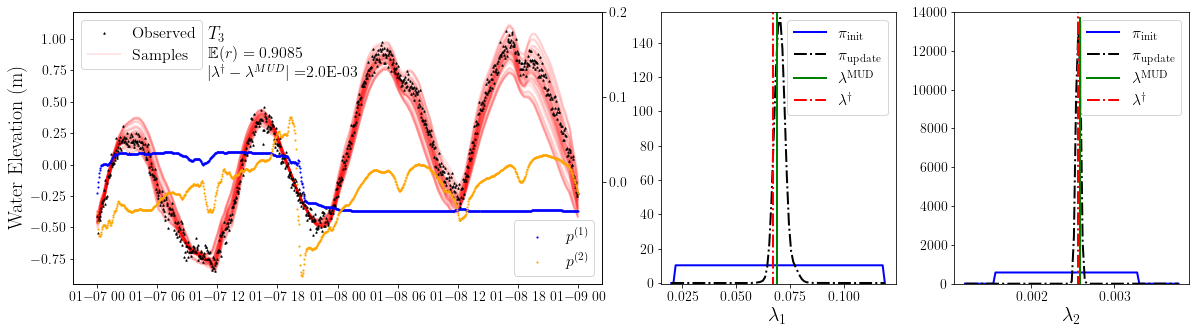

In [30]:
fig = plt.figure(figsize=(12, 5))

msize = 10
# One component
prob_5_1 = adcirc_prob.mud_problem(method="pca", num_components=1, times_mask=t1_mask)
mud_pt_5_1 = prob_5_1.estimate()
err = np.linalg.norm(raw_data["lam_ref"] - mud_pt_5_1)

# Two components
prob_5_2c = adcirc_prob.mud_problem(method="pca", num_components=2, times_mask=t4_mask)
mud_pt_5_2c = prob_5_2c.estimate()
err_2 = np.linalg.norm(raw_data["lam_ref"] - mud_pt_5_2c)

exp_r_1_str = f"$\mathbb{{E}}(r_1) = {prob_5.exp_r():0.4}$"
exp_r_2_str = f"$\mathbb{{E}}(r_2) = {prob_5_2c.exp_r():0.4}$"

# Plot Lambda 1
domain = np.array([[0.02, 0.12], [0.0012, 0.0038]])
ax = fig.add_subplot(1, 2, 1)
ax.set_ylim([-0.41, 65])
prob_5.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(1)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(1)}$"},
)
prob_5_2c.plot_param_space(
    ax=ax,
    param_idx=0,
    x_range=domain,
    in_opts=None,
    up_opts={"linestyle": ":", "label": "$\pi_\\text{update}^{(2)}$"},
    mud_opts={"linestyle": ":", "label": "$\lambda_\\text{MUD}^{(2)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.41, 65])
ax.legend()

height = 1600
ax = fig.add_subplot(1, 2, 2)
ax.set_ylim([-0.01, height])
prob_5.plot_param_space(
    ax=ax,
    x_range=domain,
    param_idx=1,
    up_opts={"linestyle": "--", "label": "$\pi_\\text{update}^{(1)}$"},
    mud_opts={"linestyle": "--", "label": "$\lambda_\\text{MUD}^{(1)}$"},
)
prob_5_2c.plot_param_space(
    ax=ax,
    param_idx=1,
    x_range=domain,
    in_opts=None,
    up_opts={"linestyle": ":", "label": "$\pi_\\text{update}^{(2)}$"},
    mud_opts={"linestyle": ":", "label": "$\lambda_\\text{MUD}^{(2)}$"},
    true_val=raw_data["lam_ref"],
    true_opts={"color": "r"},
)
ax.set_ylim([-0.01, height])
ax.legend()

# fig.subplots_adjust(wspace=0.25)
fig.suptitle(f"$T_5$ : {exp_r_1_str}, {exp_r_2_str}", fontsize=20)

save_figure(
    "pca_t5_res_3", "ADCIRC", close_fig=False, dpi=resolution, bbox_inches="tight"
)

# Appendices

## Appendix A - Re-formatting data

Re-formatting existing ADCIRC data file

In [6]:
df = "ADCIRC/si-inlet.pickle"
with open(df, "rb") as fp:
    raw_data = pickle.load(fp)


new_data = {}
new_data["lam"] = raw_data["lam"]
new_data["data"] = raw_data["qoi"].T
new_data["true_vals"] = raw_data["qoi_true"]
new_data["lam_ref"] = raw_data["true_lambda"]
new_data["domain"] = raw_data["domain"]
new_data["times"] = raw_data["times"]
new_data["met_data"] = wind_data["met_data"]

new_df = "ADCIRC/si-inlet3.pickle"
with open(new_df, "wb") as fp:
    pickle.dump(new_data, fp)

### Wind Data

In [3]:
wind_df = "ADCIRC/full_ds.pickle"
with open(wind_df, "rb") as fp:
    wind_data = pickle.load(fp)
wind_data.keys()
met_data = wind_data["met_data"]

## Appendix B - Getting all data from raw ensemble output

In [8]:
df = "~/repos/MUD-ADCIRC/data/si_jan_pred.nc"

import xarray as xa

ds = xa.open_dataset(df)
ds

<xarray.Dataset>
Dimensions:        (sample: 1000, param: 2, time: 6240, node: 3)
Coordinates:
  * sample         (sample) int64 125 1279 1844 1330 1781 ... 933 559 1578 1 193
  * param          (param) object '\\lambda_0' '\\lambda_1'
  * time           (time) datetime64[ns] 2018-01-01T00:03:00 ... 2018-01-14
    x              (node) float64 ...
    y              (node) float64 ...
  * node           (node) int64 1362 2484 2833
Data variables:
    param_samples  (sample, param) float64 ...
    water_levels   (node, sample, time) float64 ...

In [9]:
with open("ADCIRC/full_ds.pickle", "rb") as fp:
    ds2 = pickle.load(fp)

ds2["true_lambda"]

array([0.06724306, 0.00256819])

In [10]:
samples_idx = np.all(ds["param_samples"] != ds2["true_lambda"], axis=1)
true_sample_idx = 125

In [11]:
new_ds = {
    "lam": ds["param_samples"].sel(sample=samples_idx).to_numpy(),
    "data": ds["water_levels"].sel(sample=samples_idx).to_numpy().reshape(999, 3, 6240),
    "true_vals": ds["water_levels"].sel(sample=125).to_numpy(),
    "sensors": np.dstack([ds["x"], ds["y"]])[0],
    "times": ds["time"].to_numpy(),
    "lam_ref": ds["param_samples"].sel(sample=125).to_numpy(),
    "domain": np.array([[0.0335, 0.1005], [0.00125, 0.00375]]),
}
[(x, new_ds[x].shape) for x in new_ds.keys()]

[('lam', (999, 2)),
 ('data', (999, 3, 6240)),
 ('true_vals', (3, 6240)),
 ('sensors', (3, 2)),
 ('times', (6240,)),
 ('lam_ref', (2,)),
 ('domain', (2, 2))]

In [12]:
with open("ADCIRC/si-ds.pickle", "wb") as fp:
    pickle.dump(new_ds, fp)

In [6]:
raw_data, adcirc_prob = load_adcirc_prob("ADCIRC/si-ds.pickle")

## Appendix C - Experimenting with visualizing PCA vectors for time-series

Playing around here with using pca vectors weights to control size of measurement dot.

Question - Negative values. Do we just plot absolute value of weights? Or absolute distance to wme weight value?
Observation - Inflection points (change in second derivative) appear to coincide with crosses/intersections with WME value.

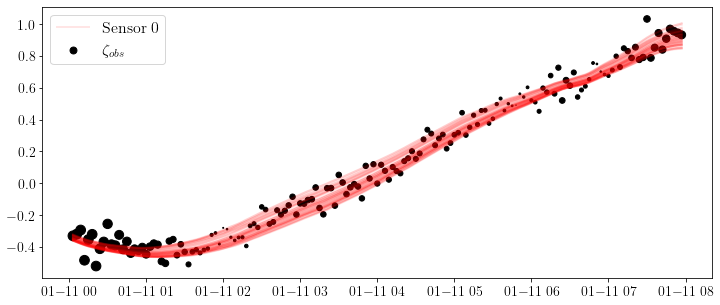

In [44]:
mean_weight = 0  # np.mean(adcirc_prob.pca['vecs'][0])
lt = adcirc_prob.pca["vecs"][1] < mean_weight
gt = adcirc_prob.pca["vecs"][1] > mean_weight
lt_times = adcirc_prob.times[t1_mask][lt]
gt_times = adcirc_prob.times[t1_mask][gt]
lt_vals = np.abs(adcirc_prob.pca["vecs"][1][lt] - mean_weight)
gt_vals = adcirc_prob.pca["vecs"][1][gt] - mean_weight
df = pd.concat(
    [
        pd.DataFrame({"times": lt_times, "vals": lt_vals}),
        pd.DataFrame({"times": gt_times, "vals": gt_vals}),
    ]
)
s = 500 * df.sort_values(by="times")["vals"].to_numpy()

ax = adcirc_prob.plot_ts(
    times=t1_mask, max_plot=50, meas_kwargs={"marker": "o", "s": s}
)
ax.legend()

## Appendix D - Getting Open Street Data 


In [115]:
import math

URL = "https://tile.openstreetmap.org/{z}/{x}/{y}".format

TILE_SIZE = 256


def point_to_pixels(lon, lat, zoom):
    """convert gps coordinates to web mercator"""
    r = math.pow(2, zoom) * TILE_SIZE
    lat = math.radians(lat)

    x = int((lon + 180.0) / 360.0 * r)
    y = int((1.0 - math.log(math.tan(lat) + (1.0 / math.cos(lat))) / math.pi) / 2.0 * r)

    return x, y


zoom = 16
# x, y = point_to_pixels(xcenter, ycenter, zoom)
x, y = point_to_pixels(-90.064279, 29.95863, zoom)

x_tiles, y_tiles = int(x / TILE_SIZE), int(y / TILE_SIZE)
x_tiles, y_tiles

(16372, 27047)

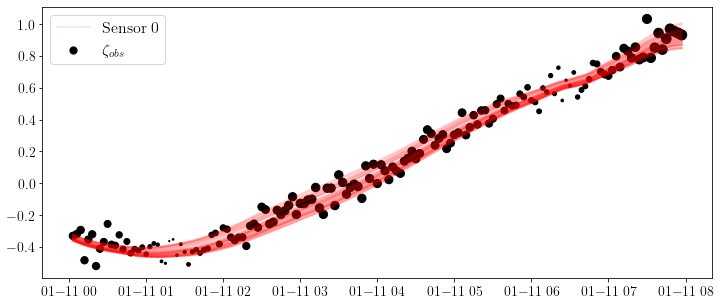

In [45]:
mean_weight = np.mean(adcirc_prob.pca["vecs"][0])
lt = adcirc_prob.pca["vecs"][1] < mean_weight
gt = adcirc_prob.pca["vecs"][1] > mean_weight
lt_times = adcirc_prob.times[t1_mask][lt]
gt_times = adcirc_prob.times[t1_mask][gt]
lt_vals = np.abs(adcirc_prob.pca["vecs"][1][lt] - mean_weight)
gt_vals = adcirc_prob.pca["vecs"][1][gt] - mean_weight
df = pd.concat(
    [
        pd.DataFrame({"times": lt_times, "vals": lt_vals}),
        pd.DataFrame({"times": gt_times, "vals": gt_vals}),
    ]
)
s = 500 * df.sort_values(by="times")["vals"].to_numpy()

ax = adcirc_prob.plot_ts(
    times=t1_mask, max_plot=50, meas_kwargs={"marker": "o", "s": s}
)
ax.legend()

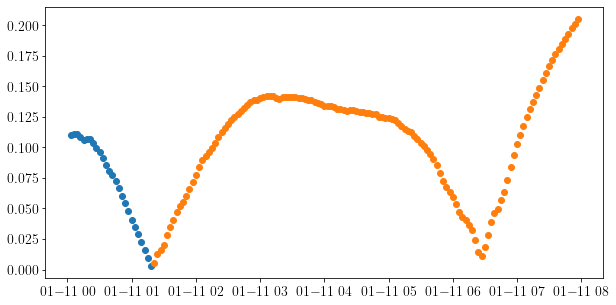

In [21]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 1, 1)
plt.scatter(lt_times, lt_vals)
plt.scatter(gt_times, gt_vals)

# ADCIRC Inputs

In [55]:
data_dir = (
    Path.cwd() / "../../pyadcirc/notebooks/data/si-mud/GD-WindMult_WindJan2018_CFSv2_12"
).resolve()
data_dir

PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/si-mud/GD-WindMult_WindJan2018_CFSv2_12')

In [56]:
!ls {data_dir}

Permissions Size User   Date Modified Git Name
drwxr-xr-x     - carlos  9 Aug 18:11   -I  /Users/carlos/repos/pyadcirc/notebooks/data/si-mud/GD-WindMult_WindJan2018_CFSv2_12/
drwxr-xr-x     - carlos  9 Aug 18:10   -I ├──  fg_temp/
.rw-r--r--   39k carlos 15 Mar 02:27   -I ├──  fort.13
.rw-r--r--  341k carlos 15 Mar 02:27   -I ├──  fort.14
.rw-r--r--   16k carlos 15 Mar 13:19   -I ├──  fort.15
.rw-r--r--   277 carlos 15 Mar 02:27   -I ├──  fort.22
.rw-r--r--  355k carlos 15 Mar 02:27   -I ├──  fort.221
.rw-r--r--  645k carlos 15 Mar 02:27   -I ├──  fort.222
.rw-r--r--  7.4k carlos  9 Aug 18:10   -I ├──  mesh.inp
.rw-r--r--   918 carlos 15 Mar 02:27   -I ├──  README.rst
.rw-r--r--  542k carlos  9 Aug 18:10   -I └──  si-inlet-mesh0001.jpg


In [10]:
data = aio.process_adcirc_configs(data_dir, met_times=[0])
data

<xarray.Dataset>
Dimensions:                (JN: 3070, JE: 5780, ELEV_BOUNDARY: 0,
                            NORMAL_BOUNDARY: 285, AttrName: 1, NODAL_ATTRS: 2,
                            TIPOTAG: 5, BOUNTAG: 5, ALPHA: 375, STATIONS: 3,
                            STATIONS_VEL: 3, STATIONS_MET: 3, time: 1,
                            latitude: 5, longitude: 7)
Coordinates: (12/15)
  * JN                     (JN) int64 1 2 3 4 5 6 ... 3066 3067 3068 3069 3070
  * JE                     (JE) int64 1 2 3 4 5 6 ... 5776 5777 5778 5779 5780
  * ELEV_BOUNDARY          (ELEV_BOUNDARY) int64 
  * NORMAL_BOUNDARY        (NORMAL_BOUNDARY) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
  * AttrName               (AttrName) object 'wind_speed_mult'
  * NODAL_ATTRS            (NODAL_ATTRS) <U19 'wind_drag_parameter' 'wind_spe...
    ...                     ...
  * STATIONS               (STATIONS) int64 0 1 2
  * STATIONS_VEL           (STATIONS_VEL) int64 0 1 2
  * STATIONS_MET           (STATIONS_MET) int64 0 1 2
  * time                   (time) datetime64[ns] 2017-12-29
  * longitude              (longitude) float64 287.0 287.2 287.4 ... 288.0 288.2
  * latitude               (latitude) float64 40.2 40.4 40.6 40.8 41.0
Data variables: (12/34)
    X                      (JN) float64 -72.06 -72.05 -72.05 ... -72.59 -72.59
    Y                      (JN) float64 40.99 40.97 40.95 ... 40.81 40.82 40.81
    DP                     (JN) float64 4.288 13.83 20.91 ... 1.747 1.5 1.5
    NHEY                   (JE) int64 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3
    NM_1                   (JE) int64 77 76 78 2 3 ... 3065 3068 3069 3065 3068
    NM_2                   (JE) int64 76 2 2 78 78 ... 3067 3064 3065 3069 3067
    ...                     ...
    YEV                    (STATIONS_VEL) float64 40.87 40.83 40.8
    XEM                    (STATIONS_MET) float64 -72.45 -72.5 -72.3
    YEM                    (STATIONS_MET) float64 40.87 40.83 40.8
    press                  (time, latitude, longitude) float64 1.013e+03 ... ...
    u_wind                 (time, latitude, longitude) float64 8.641 ... 8.465
    v_wind                 (time, latitude, longitude) float64 -8.594 ... -8.237
Attributes: (12/114)
    NWSET:           1.0
    NWBS:            0.0
    DWM:             1.0
    AGRID:           ShinnInlet
    NE:              5780
    NP:              3070
    ...              ...
    press_source:    CFSv2 1hr pressure at MSL                              2
    press_start_ts:  2017-12-29 00:00:00
    press_end_ts:    2018-02-01 00:00:00
    wind_source:     CFSv2 1hr wind speed at 10 m                           2
    wind_start_ts:   2017-12-29 00:00:00
    wind_end_ts:     2018-02-01 00:00:00

## Mesh with Wind Speed Multiplier

In [11]:
triangles = np.array([data["NM_1"] - 1, data["NM_2"] - 1, data["NM_3"] - 1]).T
triang = mtri.Triangulation(data["X"], data["Y"], triangles)

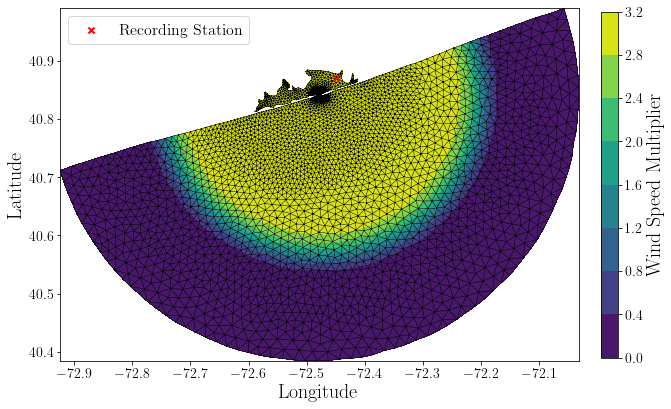

In [49]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
tcf = plt.tricontourf(triang, data["wind_speed_mult_0"])
plt.triplot(triang, linewidth="0.5", color="k")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal")
plt.colorbar(tcf, fraction=0.031, pad=0.04, label="Wind Speed Multiplier")
plt.scatter(
    data["XEL"][0], data["YEL"][0], marker="x", color="r", label="Recording Station"
)
ax.legend()

save_figure(
    "si-mesh-wind-mult", "ADCiRC", close_fig=False, dpi=500, bbox_inches="tight"
)

## Zoomed in mesh with bathymetry 

TODO - Figure out matplotlib Colorbars to make non-uniform colorbar for bathymetry like FG does



In [13]:
xcenter = -72.5
xwidth = 0.1
ycenter = 40.85
ywidth = 0.04

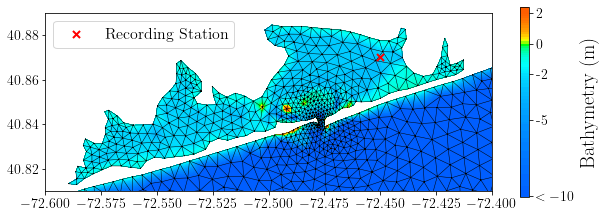

In [46]:
# make a colormap that has land and ocean clearly delineated and of the
# same length (256 + 256)
cmap = plt.cm.jet
name = "jet_map"
# cmap = plt.cm.terrain
# name = 'terrain_map'
colors_undersea = plt.cm.Blues(np.linspace(0.0, 1, 256))
colors_land = plt.cm.GnBu_r(np.linspace(0.0, 0.1, 256))
all_colors = np.vstack((colors_undersea, colors_land))

new_map = colors.LinearSegmentedColormap.from_list(
    name, plt.cm.gist_rainbow_r(np.linspace(0.3, 0.9, 256))
)

# dynamic range:
# divnorm = colors.TwoSlopeNorm(vmin=-60., vcenter=0, vmax=4)
# divnorm = colors.TwoSlopeNorm(vmin=-20., vcenter=0, vmax=4)

cutoff_val = -10
# make the norm:  Note the center is offset so that the land has more
divnorm = colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=cutoff_val, vmax=2.0)
depth = -data["DP"].to_numpy()
depth[np.where(depth < -5)] = cutoff_val
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
tcf = plt.tricontourf(triang, depth, cmap=new_map, norm=divnorm, levels=100)
plt.triplot(triang, linewidth="0.5", color="k")

zoom = True  # False
if zoom:
    ax.set_xlim([xcenter - xwidth, xcenter + xwidth])
    ax.set_ylim([ycenter - ywidth, ycenter + ywidth])
    ax.set_aspect("equal")
cb = fig.colorbar(tcf, shrink=0.35, label="Bathymetry (m)", ticks=[-10, -5, -2, 0, 2])
cb.ax.set_yticklabels(["$<-10$", "-5", "-2", "0", "2"])

# Plot recording station
plt.scatter(
    data["XEL"][0],
    data["YEL"][0],
    marker="x",
    color="r",
    label="Recording Station",
    s=50,
)
ax.legend()

save_figure(
    "si-inlet-bathymetry", "ADCiRC", close_fig=False, dpi=500, bbox_inches="tight"
)

### Using FuncNorm to Create Custom Spaced Intervals in Colorbar

ref = https://matplotlib.org/stable/tutorials/colors/colormapnorms.html

(array([  8., 577., 125.,  81., 108., 118.,  88., 102., 130., 152., 181.,
        158., 147., 130., 114., 104., 117., 101.,  94.,  85.,  76.,  57.,
         52.,  34.,  25.,  57.,  18.,  13.,  12.,   6.]),
 array([0.20722616, 0.44594903, 0.6846719 , 0.92339477, 1.16211765,
        1.40084052, 1.63956339, 1.87828626, 2.11700913, 2.35573201,
        2.59445488, 2.83317775, 3.07190062, 3.31062349, 3.54934637,
        3.78806924, 4.02679211, 4.26551498, 4.50423786, 4.74296073,
        4.9816836 , 5.22040647, 5.45912934, 5.69785222, 5.93657509,
        6.17529796, 6.41402083, 6.6527437 , 6.89146658, 7.13018945,
        7.36891232]),
 <BarContainer object of 30 artists>)

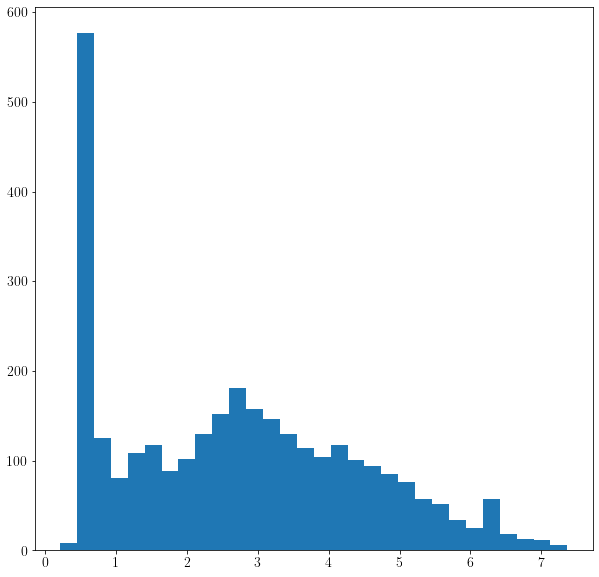

In [34]:
power = 4
x = data["DP"].to_numpy()
res = np.zeros(x.shape)
lt = x[np.where(x < 0)]
res[np.where(x < 0)] = 0.5 * (lt - 4) * 0.25 + 1
gt = x[np.where(x >= 0)]
res[np.where(x >= 0)] = (60 + gt) ** power * (1.0 / 60**power) * 0.5

fig = plt.figure()
plt.hist(res, bins=30)

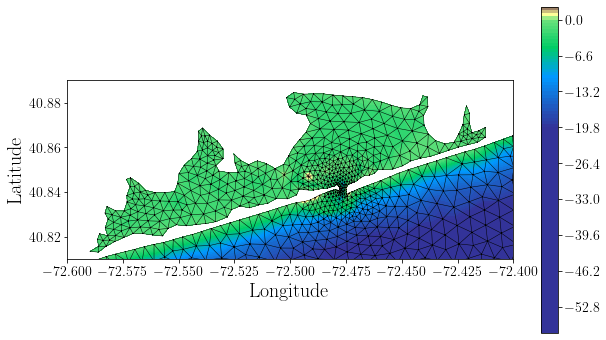

In [35]:
def _forward(x):
    power = 2
    res = np.zeros(x.shape)

    gt_idx = np.where(x >= 0)
    gt = x[gt_idx]
    res[gt_idx] = 0.5 * (gt - 4) * 0.25 + 1

    lt_idx = np.where(x < 0)
    lt = x[lt_idx]
    res[lt_idx] = (60 + lt) ** power * (1.0 / 60**power) * 0.5

    return res  # (60 + x)**power*(1./60**power)*0.5


def _inverse(x):
    power = 2
    res = np.zeros(x.shape)

    gt_idx = np.where(x >= 0.5)
    gt = x[gt_idx]
    res[gt_idx] = 8 * (gt - 4) + 1

    lt_idx = np.where(x < 0.5)
    lt = x[lt_idx]
    res[lt_idx] = np.power(np.abs(lt) * 2 * 60**power, 1 / power) - 60
    return res  # np.power(np.abs(x)*2*60**power, 1/power) -60


norm = colors.FuncNorm((_forward, _inverse), vmin=-20, vmax=4)

# cmap = plt.cm.viridis
cmap = plt.cm.terrain
# cmap = plt.cm.BrBG_r

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
tcf = plt.tricontourf(triang, -data["DP"], cmap=cmap, norm=norm, levels=100)
plt.triplot(triang, linewidth="0.5", color="k")

zoom = True  # False
if zoom:
    xcenter = -72.5
    xwidth = 0.1
    ycenter = 40.85
    ywidth = 0.04
    ax.set_xlim([xcenter - xwidth, xcenter + xwidth])
    ax.set_ylim([ycenter - ywidth, ycenter + ywidth])
    ax.set_aspect("equal")

cb = fig.colorbar(tcf, shrink=0.6)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal")

In [37]:
levels = np.hstack([np.linspace(-1, 5, 10), np.linspace(5, 60, 10)])
levels

array([-1.        , -0.33333333,  0.33333333,  1.        ,  1.66666667,
        2.33333333,  3.        ,  3.66666667,  4.33333333,  5.        ,
        5.        , 11.11111111, 17.22222222, 23.33333333, 29.44444444,
       35.55555556, 41.66666667, 47.77777778, 53.88888889, 60.        ])

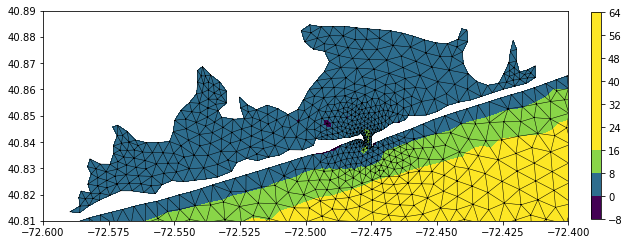

In [124]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
tcf = plt.tricontourf(triang, data["DP"], vmin=-2, vmax=15)
plt.triplot(triang, linewidth="0.5", color="k")
# ax.set_xlim([-72.7, -72.3])
# ax.set_ylim([40.75, 41])
xcenter = -72.5
xwidth = 0.1
ycenter = 40.85
ywidth = 0.04
ax.set_xlim([xcenter - xwidth, xcenter + xwidth])
ax.set_ylim([ycenter - ywidth, ycenter + ywidth])
ax.set_aspect("equal")
plt.colorbar(tcf, fraction=0.0185, pad=0.04)

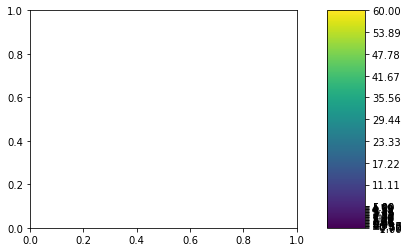

In [24]:
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        "trunc({name},{a:.2f},{b:.2f})".format(name=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap


minColor = 0
maxColor = 1
viridis = truncate_colormap(plt.get_cmap("viridis"), minColor, maxColor)

parameterToColorBy = np.linspace(-1, 5, 30, dtype=float)
parameterToColorBy = np.hstack(
    [parameterToColorBy, np.linspace(5, 60, 10, dtype=float)]
)

colors = [viridis(i) for i in np.linspace(0, 1, parameterToColorBy.shape[0])]

norm = mpl.colors.Normalize(parameterToColorBy[0], parameterToColorBy[-1])

gs = gridspec.GridSpec(1, 2, width_ratios=[7, 1])
ax = [plt.subplot(g) for g in gs]

cb = mpl.colorbar.ColorbarBase(
    ax[1], cmap=viridis, norm=norm, ticks=parameterToColorBy, orientation="vertical"
)

In [30]:
parameterToColorBy[-1]

60.0

In [87]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

tpg = [
    [0.0, 238, 47, 157],
    [0.06666666666666667, 115, 24, 143],
    [0.13333333333333333, 57, 13, 136],
    [0.2, 18, 6, 134],
    [0.26666666666666666, 16, 0, 255],
    [0.3333333333333333, 56, 84, 254],
    [0.4, 81, 166, 255],
    [0.4666666666666667, 112, 251, 254],
    [0.5333333333333333, 120, 255, 240],
    [0.6, 226, 226, 226],
    [0.6666666666666666, 100, 194, 108],
    [0.7333333333333333, 73, 169, 61],
    [0.8, 55, 145, 31],
    [0.8666666666666667, 45, 123, 24],
    [0.9333333333333333, 35, 98, 19],
    [1.0, 26, 76, 13],
]
tpg = [[x if i == 0 else x / 255.0 for i, x in enumerate(vals)] for vals in tpg]
tpg = [vals[1:4] + [1.0] for vals in tpg]
tpg

[[0.9333333333333333, 0.1843137254901961, 0.615686274509804, 1.0],
 [0.45098039215686275, 0.09411764705882353, 0.5607843137254902, 1.0],
 [0.2235294117647059, 0.050980392156862744, 0.5333333333333333, 1.0],
 [0.07058823529411765, 0.023529411764705882, 0.5254901960784314, 1.0],
 [0.06274509803921569, 0.0, 1.0, 1.0],
 [0.2196078431372549, 0.32941176470588235, 0.996078431372549, 1.0],
 [0.3176470588235294, 0.6509803921568628, 1.0, 1.0],
 [0.4392156862745098, 0.984313725490196, 0.996078431372549, 1.0],
 [0.47058823529411764, 1.0, 0.9411764705882353, 1.0],
 [0.8862745098039215, 0.8862745098039215, 0.8862745098039215, 1.0],
 [0.39215686274509803, 0.7607843137254902, 0.4235294117647059, 1.0],
 [0.28627450980392155, 0.6627450980392157, 0.23921568627450981, 1.0],
 [0.21568627450980393, 0.5686274509803921, 0.12156862745098039, 1.0],
 [0.17647058823529413, 0.4823529411764706, 0.09411764705882353, 1.0],
 [0.13725490196078433, 0.3843137254901961, 0.07450980392156863, 1.0],
 [0.10196078431372549, 0.

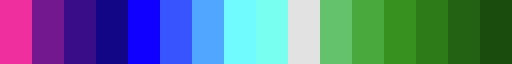

In [88]:
ListedColormap(tpg)

In [67]:
tbg = [
    [0.0, 0, 0, 130],
    [0.25, 0, 0, 255],
    [0.5, 0, 255, 255],
    [0.62, 107, 195, 135],
    [0.81, 0, 128, 0],
    [1.0, 0, 64, 0],
]
tbg = [[x if i == 0 else x / 255.0 for i, x in enumerate(vals)] for vals in tbg]
tbg = [vals[1:4] + [1.0] for vals in tbg]
tbg

[[0.0, 0.0, 0.5098039215686274, 1.0],
 [0.0, 0.0, 1.0, 1.0],
 [0.0, 1.0, 1.0, 1.0],
 [0.4196078431372549, 0.7647058823529411, 0.5294117647058824, 1.0],
 [0.0, 0.5019607843137255, 0.0, 1.0],
 [0.0, 0.25098039215686274, 0.0, 1.0]]

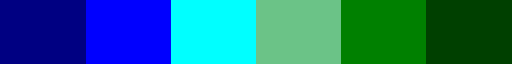

In [70]:
tbg_cmap = ListedColormap(tbg, name="topo-blue-green")
tbg_cmap

In [ ]:
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        "trunc({name},{a:.2f},{b:.2f})".format(name=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap


minColor = 0
maxColor = 1
viridis = truncate_colormap(plt.get_cmap("viridis"), minColor, maxColor)

parameterToColorBy = np.linspace(-1, 5, 30, dtype=float)
parameterToColorBy = np.hstack(
    [parameterToColorBy, np.linspace(5, 60, 10, dtype=float)]
)

colors = [viridis(i) for i in np.linspace(0, 1, parameterToColorBy.shape[0])]

norm = mpl.colors.Normalize(parameterToColorBy[0], parameterToColorBy[-1])

gs = gridspec.GridSpec(1, 2, width_ratios=[7, 1])
ax = [plt.subplot(g) for g in gs]

cb = mpl.colorbar.ColorbarBase(
    ax[1], cmap=viridis, norm=norm, ticks=parameterToColorBy, orientation="vertical"
)

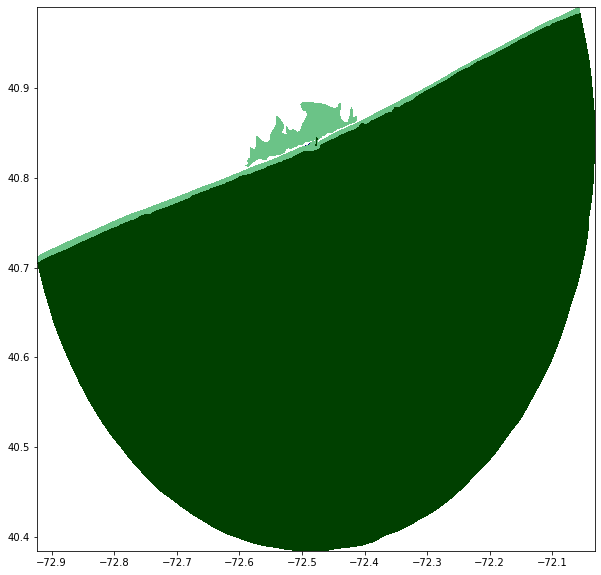

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import BoundaryNorm, ListedColormap

tbg_cmap = ListedColormap(tbg, name="topo-blue-green")
bounds = [-1, 0, 1, 2, 5, 10]
norm = BoundaryNorm(bounds, tbg_cmap.N)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
tcf = plt.tricontourf(triang, data["DP"], cmap=tbg_cmap, norm=norm)

In [95]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

# make these smaller to increase the resolution
dx, dy = 0.05, 0.05

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(1, 5 + dy, dy), slice(1, 5 + dx, dx)]

z = np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
levels = MaxNLocator(nbins=6).tick_values(z.min(), z.max())

In [96]:
levels

array([-1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2])

In [97]:
norm = BoundaryNorm(levels, ncolors=tbg_cmap.N)

<xarray.DataArray 'DP' (JN: 3070)>
array([ True,  True, False, ...,  True,  True,  True])
Coordinates:
  * JN       (JN) int64 1 2 3 4 5 6 7 8 ... 3064 3065 3066 3067 3068 3069 3070

In [37]:
idxs = np.where(data["DP"] < 20)[0]
idxs.shape

(993,)

In [38]:
triangles = np.array([data["NM_1"] - 1, data["NM_2"] - 1, data["NM_3"] - 1]).T
triangles

array([[  76,   75,    0],
       [  75,    1,    0],
       [  77,    1,   75],
       ...,
       [3068, 3064, 3065],
       [3064, 3068, 3066],
       [3067, 3066, 3069]])

In [ ]:
[[y for y in triangles if x in y] for x in idxs]

In [ ]:
triangles = np.array(
    [data["NM_1"][idxs] - 1, data["NM_2"][idxs] - 1, data["NM_3"][idxs] - 1]
).T
triang = mtri.Triangulation(data["X"][idxs], data["Y"][idxs], triangles)
plt.triplot(triang, linewidth="0.5", color="k")